## Elliptic Curves

Elliptic curves can be created easily with the command EllipticCurve

Suppose we want to create the curve $y^2 = x^3 + x + 1 \mod 13$


In [1]:
p = 13
b = 1
c = 1

E = EllipticCurve(Zmod(p),[b,c])
print(E)

Elliptic Curve defined by y^2 = x^3 + x + 1 over Ring of integers modulo 13


We can check if the curve is singular

In [2]:
E.is_singular()

False

We can plot the curve

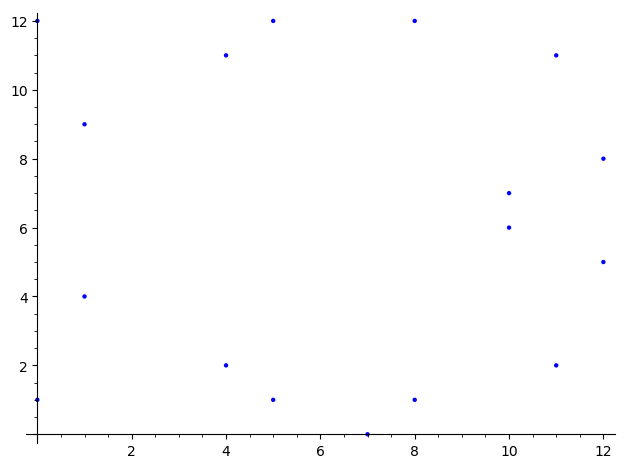

In [3]:
E.plot()

How many points?

In [4]:
E.order()

18

We can do that only because the curve is small. We can also print the points.

In [5]:
E.points()

[(0 : 1 : 0), (0 : 1 : 1), (0 : 12 : 1), (1 : 4 : 1), (1 : 9 : 1), (4 : 2 : 1), (4 : 11 : 1), (5 : 1 : 1), (5 : 12 : 1), (7 : 0 : 1), (8 : 1 : 1), (8 : 12 : 1), (10 : 6 : 1), (10 : 7 : 1), (11 : 2 : 1), (11 : 11 : 1), (12 : 5 : 1), (12 : 8 : 1)]

Sagemath uses projective coordinates, so the points have three coordinates (x,y,z).
z is always equal to 1, except for the infinity, which has z = 0.
In sagemath the point at infinity is (0:1:0).

If we do not have the infinity, we can write the points in the usual (x,y) coordinates using E.xy()

In [6]:
[P.xy() for P in E.points()[1:] ]

[(0, 1),
 (0, 12),
 (1, 4),
 (1, 9),
 (4, 2),
 (4, 11),
 (5, 1),
 (5, 12),
 (7, 0),
 (8, 1),
 (8, 12),
 (10, 6),
 (10, 7),
 (11, 2),
 (11, 11),
 (12, 5),
 (12, 8)]

Let's find a generator

In [7]:
E.gens()

((1 : 9 : 1),)

In some domains you need multiple generators, so the function returns a tuple of generators. In our case a single generator is sufficient.

In [8]:
P=E.gens()[0]
print(P.xy())

(1, 9)


Let's see the order

In [9]:
P.order()

18

Sagemath tells that the order is 18, but we want to verify.

To verify that P is a generator, we multiply it by the divisors of the number of points $n$ and verify that the result is not infinity.

If the factorization of the number of points is $n=\sum p_i^{a_i}$, it is sufficient to try all the $N/p_i$

In [10]:
print("9P is: %s" % (9*P))
print("6P is: %s" % (6*P))

9P is: (7 : 0 : 1)
6P is: (10 : 7 : 1)


We can also list the points or draw them in a wheel

In [17]:
[i*P for i in range(order(P))]

[(0 : 1 : 0),
 (1 : 9 : 1),
 (8 : 1 : 1),
 (0 : 1 : 1),
 (11 : 2 : 1),
 (5 : 12 : 1),
 (10 : 7 : 1),
 (12 : 5 : 1),
 (4 : 11 : 1),
 (7 : 0 : 1),
 (4 : 2 : 1),
 (12 : 8 : 1),
 (10 : 6 : 1),
 (5 : 1 : 1),
 (11 : 11 : 1),
 (0 : 12 : 1),
 (8 : 12 : 1),
 (1 : 4 : 1)]

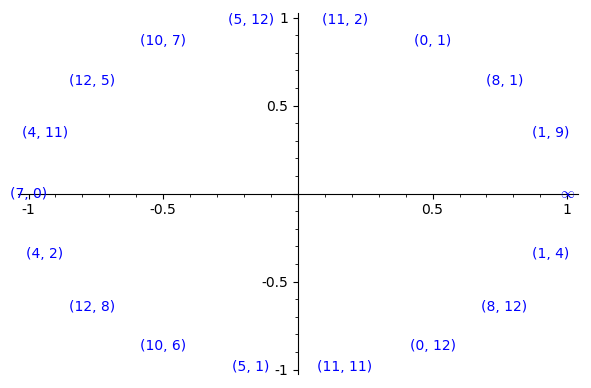

In [18]:
#g = list_plot([(cos(2*pi*t/order(P)),sin(2*pi*t/order(P))) for t in range(order(P))])
g = text(r"$\infty$",(1,0))
for t in range(1,order(P)):
    g += text((t*P).xy(),(cos(2*pi*t/order(P)),sin(2*pi*t/order(P))))
g

## ECDSA

We now execute some real ECDSA using a standard curve.

In [19]:
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.asymmetric import ec
from cryptography.hazmat.primitives.asymmetric.utils import decode_dss_signature

We use NIST curve SECP384r1. The key size is 384 bits.
There is no need to generate parameters, because the standard already provides the curve equation, a generator and its order.

We proceed with the generation of a private key and of the corresponding public key.

In [33]:
private_key = ec.generate_private_key(
    ec.SECP384R1(), default_backend()
    )
print("Private key is: %d" % private_key.private_numbers().private_value)

Private key is: 33116702632925456467471543954722153581240061404579606490301797715878614527002926702292647143326474178867729984324926


In [34]:
public_key = private_key.public_key()
print("Public key is : (%s,%s)" % (public_key.public_numbers().x,public_key.public_numbers().y))

Public key is : (5249236418722360737785283926114280323143441693407168724134026998666168534286801355530452427204549341848292156952436,2400253076419321484909647344421940597552893651248320872376646124319909998215450948831257556852839652193855939190758)


Remember that the private key is an integer, while the public key is a point. Now we can sign a message.
The signature will be encoded using the DER rules, so it will be a string of bits.

In [22]:
data = b"this is some data I'd like to sign"
signature = private_key.sign(
    data,
    ec.ECDSA(hashes.SHA256())
    )
print(signature.hex())

306502304aa9cab3b4aa86bbebf7b52a9355e83beb2dce1fbbf84c72659ef59f1e7b9e41e303896e31927c05429492d0f1ae94e2023100a59c9eda1316c053b5c4a14e59cc5762f2216fa18957d4401749a4d8186d772a6f2e9d4cae9f72f16410ef056eefde90


The DSA signature is randomized, so if we run the algorithm again we get a different signature. The interface does not ask for a nonce, so we cannot make the mistake of providing repeated nonces.

In [24]:
signature = private_key.sign(
    data,
    ec.ECDSA(hashes.SHA256())
    )
print(signature.hex())

30650230604981635bbd9a19f8dae87f3d51fc3a1f871c789515e9144a6e8f20f5807fb2c40871d5b5bea83b12a7c42289a8425b023100f52dfe6aa981c40516cd8686ab24472749ecd5690593df8c9657aedde3eaaf4b0fced3d3b7fa8c98828430c448016466


We can decode the signature and retrieve the parameters $r$ and $s$

In [25]:
(r,s)=decode_dss_signature(signature)
print("r = %d\ns = %d" % (r,s) )

r = 14819945760941046450528965501454069975628264105719125264612264585123295913956595614474061646985335738951695327576667
s = 37736603961530581136830217433410930613637373997625320347253775268047990267890835045781240759677863118787543293846630


We can verify the signature using the public key. If the signature is wrong, we get an exception

In [26]:
try:
    public_key.verify(signature,data,ec.ECDSA(hashes.SHA256()))
    print("OK")
except:
    print("KO")

OK


What happens if the message was modified?

In [27]:
modified_data = b"this is some forged data I'd like to sign"
try:
    public_key.verify(signature,modified_data,ec.ECDSA(hashes.SHA256()))
    print("OK")
except:
    print("KO")

KO


## Elliptic Curve
Let's play a bit with the SECP384r1 curve. The parameters are the following:

In [35]:
p = 2^384 - 2^128 - 2^96 + 2^32 - 1
b = -3
c = 27580193559959705877849011840389048093056905856361568521428707301988689241309860865136260764883745107765439761230575
gx = 0xaa87ca22be8b05378eb1c71ef320ad746e1d3b628ba79b9859f741e082542a385502f25dbf55296c3a545e3872760ab7
gy = 0x3617de4a96262c6f5d9e98bf9292dc29f8f41dbd289a147ce9da3113b5f0b8c00a60b1ce1d7e819d7a431d7c90ea0e5f
ordg = 39402006196394479212279040100143613805079739270465446667946905279627659399113263569398956308152294913554433653942643

In [36]:
E = EllipticCurve(Zmod(p),[b,c])
G = E(gx,gy)
print("E = %s" % E)
print("G = (\n%d,\n%d)" % G.xy())

E = Elliptic Curve defined by y^2 = x^3 + 39402006196394479212279040100143613805079739270465446667948293404245721771496870329047266088258938001861606973112316*x + 27580193559959705877849011840389048093056905856361568521428707301988689241309860865136260764883745107765439761230575 over Ring of integers modulo 39402006196394479212279040100143613805079739270465446667948293404245721771496870329047266088258938001861606973112319
G = (
26247035095799689268623156744566981891852923491109213387815615900925518854738050089022388053975719786650872476732087,
8325710961489029985546751289520108179287853048861315594709205902480503199884419224438643760392947333078086511627871)


Is the curve singular?

In [37]:
E.is_singular()

False

Let's verify that the order of $G$ is correct.

In [38]:
ordg*G

(0 : 1 : 0)

Ok, but what about the factors?

In [39]:
is_prime(ordg)

True

Oh, the order of $G$ is prime. The standard also says that $G$ is a generator of the curve. Let's compare it with Hasse's theorem.

In [40]:
abs(ordg-(p+1)) < 2*sqrt(p+0.0)

True

Ok, it is consistent with Hasse's theorem.

Now we can try to calculate the public key from the private key.

In [41]:
P = private_key.private_numbers().private_value * G
P.xy()

(5249236418722360737785283926114280323143441693407168724134026998666168534286801355530452427204549341848292156952436,
 2400253076419321484909647344421940597552893651248320872376646124319909998215450948831257556852839652193855939190758)

Compare that to the public key calculated with the openssl library

In [42]:
public_key.public_numbers()

<EllipticCurvePublicNumbers(curve=secp384r1, x=5249236418722360737785283926114280323143441693407168724134026998666168534286801355530452427204549341848292156952436, y=2400253076419321484909647344421940597552893651248320872376646124319909998215450948831257556852839652193855939190758>